In [1]:
# Install core dependencies
!pip -q install --upgrade pip
!pip -q install wandb tqdm pandas matplotlib
!pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121

# Clone and install the PerforatedAI library
!rm -rf /content/PerforatedAI
!git clone https://github.com/PerforatedAI/PerforatedAI.git /content/PerforatedAI
%cd /content/PerforatedAI
!pip -q install -e .

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.6 MB/s eta 0:00:00
Cloning into '/content/PerforatedAI'...
remote: Enumerating objects: 1515, done.
remote: Counting objects: 100% (463/463), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 1515 (delta 310), reused 335 (delta 283), pack-reused 1052 (from 3)
Receiving objects: 100% (1515/1515), 78.78 MiB | 21.21 MiB/s, done.
Resolving deltas: 100% (825/825), done.
/content/PerforatedAI
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for perforatedai (pyproject.toml) ... done


In [2]:
import os, time, copy, random
import numpy as np
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from perforatedai import globals_perforatedai as GPA
from perforatedai import utils_perforatedai as UPA
import wandb

# --- CONFIGURATION & SEEDING ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

WANDB_PROJECT = "perforatedai-hackathon-cifar10-PR"

# --- RELIABILITY SETTINGS ---
# Bypass the "pdb" interactive trace and confirmed settings for headless Colab runs
GPA.pc.set_unwrapped_modules_confirmed(True)
GPA.pc.set_weight_decay_accepted(True)
GPA.pc.set_testing_dendrite_capacity(False)

Building dendrites without Perforated Backpropagation


In [3]:
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

# Added AutoAugment to reduce overfitting (CTO recommendation)
train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tfms)
test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tfms)

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 170M/170M [00:03<00:00, 43.5MB/s]


In [4]:
def make_resnet18_cifar10():
    m = torchvision.models.resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, 10)
    return m

def make_shufflenetv2_cifar10():
    m = torchvision.models.shufflenet_v2_x1_0(weights=None)
    m.fc = nn.Linear(m.fc.in_features, 10)
    return m

@torch.no_grad()
def evaluate_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)
    return correct / max(total, 1)

def count_params(model):
    return sum(p.numel() for p in model.parameters())

@torch.no_grad()
def benchmark_latency(model, loader, n_batches=30):
    model.eval()
    it = iter(loader)
    for _ in range(10): # Warmup
        x, _ = next(it)
        model(x.to(device))
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(n_batches):
        x, _ = next(it)
        model(x.to(device))
    torch.cuda.synchronize()
    return (time.time() - start) / n_batches

In [5]:
def train_plain(model, run_name, lr=0.05, epochs=20):
    run = wandb.init(project=WANDB_PROJECT, name=run_name, reinit=True)
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()

    hist = {"epoch": [], "train_acc": [], "test_acc": [], "params": []}

    best_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
        scheduler.step()

        train_acc = evaluate_accuracy(model, train_loader)
        test_acc  = evaluate_accuracy(model, test_loader)

        if test_acc > best_acc:
            best_acc = test_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        hist["epoch"].append(epoch)
        hist["train_acc"].append(train_acc)
        hist["test_acc"].append(test_acc)
        hist["params"].append(count_params(model))

        wandb.log({
            "epoch": epoch,
            "train/accuracy": train_acc,
            "val/accuracy": test_acc,
            "params": count_params(model),
        })

        print(f"[{run_name}] Epoch {epoch} | Train: {train_acc:.4f} | Test: {test_acc:.4f}")

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    run.finish()
    return model, hist, best_acc

In [6]:
def train_with_dendrites(model, run_name, lr=3e-4, safety_max_epochs=200):
    run = wandb.init(project=WANDB_PROJECT, name=run_name, reinit=True)

    # --- convert to PAI BEFORE .to(device) ---
    model = UPA.initialize_pai(model)
    model = model.to(device)

    # --- PAI-managed optimizer/scheduler ---
    GPA.pai_tracker.set_optimizer(torch.optim.AdamW)
    GPA.pai_tracker.set_scheduler(torch.optim.lr_scheduler.ReduceLROnPlateau)

    # NOTE: PerforatedAI often prefers no weight decay; keep small or set 0.0 if needed
    optim_args = {"params": model.parameters(), "lr": lr, "weight_decay": 1e-4}
    sched_args = {"mode": "max", "patience": 5, "factor": 0.5}

    optimizer, _ = GPA.pai_tracker.setup_optimizer(model, optim_args, sched_args)

    # regularization
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # --- HISTORY ---
    hist_C = {
        "epoch": [],
        "train_acc": [],
        "test_acc": [],
        "params": [],
        "restructured_epoch": []
    }

    epoch = 0
    while epoch < safety_max_epochs:
        # ---- train epoch ----
        model.train()
        for x, y in train_loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

        # ---- metrics ----
        train_acc = evaluate_accuracy(model, train_loader)
        test_acc  = evaluate_accuracy(model, test_loader)

        # Add train score to PAI graph
        GPA.pai_tracker.add_extra_score(train_acc, "Train Accuracy")

        # PAI restructure / early stop decision uses validation score
        model, restructured, training_complete = GPA.pai_tracker.add_validation_score(test_acc, model)
        model = model.to(device)

        if restructured:
            hist_C["restructured_epoch"].append(epoch)
            optimizer, _ = GPA.pai_tracker.setup_optimizer(model, optim_args, sched_args)

        # ---- log history ----
        hist_C["epoch"].append(epoch)
        hist_C["train_acc"].append(train_acc)
        hist_C["test_acc"].append(test_acc)
        hist_C["params"].append(sum(p.numel() for p in model.parameters()))

        wandb.log({
            "epoch": epoch,
            "train/accuracy": train_acc,
            "val/accuracy": test_acc,
            "pai/restructured": int(restructured),
            "pai/training_complete": int(training_complete),
            "pai/params": hist_C["params"][-1],
        })

        print(f"[C] epoch={epoch:03d} train_acc={train_acc:.4f} test_acc={test_acc:.4f} "
              f"restructured={restructured} params={hist_C['params'][-1]}")

        if training_complete:
            print("training_complete=True (PAI stopped).")
            break

        epoch += 1

    run.finish()
    return model, hist_C

## W&B Key - "4d4d4c8f520ba4f560db3da3a2e051523a812c46"

In [7]:
# Run Baseline A
model_A = make_resnet18_cifar10()
model_A, hist_A, best_A = train_plain(
    model_A,
    run_name="A_ResNet18_no_dendrites",
    lr=0.05,
    epochs=20
)
lat_A = benchmark_latency(model_A, test_loader)
print("Best A accuracy:", best_A)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: warkevishal29 (warkevishal292) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


[A_ResNet18_no_dendrites] Epoch 0 | Train: 0.3547 | Test: 0.4408
[A_ResNet18_no_dendrites] Epoch 1 | Train: 0.5137 | Test: 0.5835
[A_ResNet18_no_dendrites] Epoch 2 | Train: 0.5974 | Test: 0.6647
[A_ResNet18_no_dendrites] Epoch 3 | Train: 0.6129 | Test: 0.6814
[A_ResNet18_no_dendrites] Epoch 4 | Train: 0.6677 | Test: 0.7299
[A_ResNet18_no_dendrites] Epoch 5 | Train: 0.7209 | Test: 0.7747
[A_ResNet18_no_dendrites] Epoch 6 | Train: 0.7288 | Test: 0.7821
[A_ResNet18_no_dendrites] Epoch 7 | Train: 0.7699 | Test: 0.8144
[A_ResNet18_no_dendrites] Epoch 8 | Train: 0.7880 | Test: 0.8394
[A_ResNet18_no_dendrites] Epoch 9 | Train: 0.8024 | Test: 0.8482
[A_ResNet18_no_dendrites] Epoch 10 | Train: 0.7906 | Test: 0.8334
[A_ResNet18_no_dendrites] Epoch 11 | Train: 0.8346 | Test: 0.8679
[A_ResNet18_no_dendrites] Epoch 12 | Train: 0.8399 | Test: 0.8768
[A_ResNet18_no_dendrites] Epoch 13 | Train: 0.8530 | Test: 0.8809
[A_ResNet18_no_dendrites] Epoch 14 | Train: 0.8708 | Test: 0.8916
[A_ResNet18_no_dendr

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
params,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▃▄▄▅▆▆▆▆▇▇▇▇▇██████
val/accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇██████
epoch,19
params,11173962
train/accuracy,0.90788
val/accuracy,0.9155


Best A accuracy: 0.9162


In [8]:
# Run Baseline B
model_B = make_shufflenetv2_cifar10()
model_B, hist_B, best_B = train_plain(
    model_B,
    run_name="B_ShuffleNet_no_dendrites",
    lr=0.05,
    epochs=20
)
lat_B = benchmark_latency(model_B, test_loader)
print("Best B accuracy:", best_B)



[B_ShuffleNet_no_dendrites] Epoch 0 | Train: 0.2665 | Test: 0.3604
[B_ShuffleNet_no_dendrites] Epoch 1 | Train: 0.3417 | Test: 0.4335
[B_ShuffleNet_no_dendrites] Epoch 2 | Train: 0.3785 | Test: 0.4782
[B_ShuffleNet_no_dendrites] Epoch 3 | Train: 0.3973 | Test: 0.5027
[B_ShuffleNet_no_dendrites] Epoch 4 | Train: 0.4360 | Test: 0.5346
[B_ShuffleNet_no_dendrites] Epoch 5 | Train: 0.4418 | Test: 0.5363
[B_ShuffleNet_no_dendrites] Epoch 6 | Train: 0.4548 | Test: 0.5384
[B_ShuffleNet_no_dendrites] Epoch 7 | Train: 0.4575 | Test: 0.5428
[B_ShuffleNet_no_dendrites] Epoch 8 | Train: 0.4806 | Test: 0.5645
[B_ShuffleNet_no_dendrites] Epoch 9 | Train: 0.4961 | Test: 0.5813
[B_ShuffleNet_no_dendrites] Epoch 10 | Train: 0.5097 | Test: 0.5981
[B_ShuffleNet_no_dendrites] Epoch 11 | Train: 0.5143 | Test: 0.6075
[B_ShuffleNet_no_dendrites] Epoch 12 | Train: 0.5185 | Test: 0.6201
[B_ShuffleNet_no_dendrites] Epoch 13 | Train: 0.5413 | Test: 0.6331
[B_ShuffleNet_no_dendrites] Epoch 14 | Train: 0.5534 | Tes

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
params,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▃▃▄▅▅▅▅▆▆▆▆▆▇▇▇████
val/accuracy,▁▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇████
epoch,19
params,1263854
train/accuracy,0.59582
val/accuracy,0.6731


Best B accuracy: 0.6731


In [9]:
# Run Dendrite Model C
model_C = make_shufflenetv2_cifar10()

model_C, hist_C = train_with_dendrites(
    model_C,
    run_name="C_ShuffleNet_Dendrites",
    lr=3e-4,
    safety_max_epochs=200
)

Running Dendrite Experiment
Adding validation score 0.22620000
Checking PAI switch with mode n, switch mode DOING_HISTORY, epoch 0, last improved epoch 0, total epochs 0, n: 10, num_cycles: 0
Returning False - no triggers to switch have been hit
[C] epoch=000 train_acc=0.1723 test_acc=0.2262 restructured=0 params=2511528
Adding validation score 0.29810000
Checking PAI switch with mode n, switch mode DOING_HISTORY, epoch 1, last improved epoch 1, total epochs 1, n: 10, num_cycles: 0
Returning False - no triggers to switch have been hit
[C] epoch=001 train_acc=0.2314 test_acc=0.2981 restructured=0 params=2511528
Adding validation score 0.33960000
Checking PAI switch with mode n, switch mode DOING_HISTORY, epoch 2, last improved epoch 2, total epochs 2, n: 10, num_cycles: 0
Returning False - no triggers to switch have been hit
[C] epoch=002 train_acc=0.2642 test_acc=0.3396 restructured=0 params=2511528
Adding validation score 0.39470000
Checking PAI switch with mode n, switch mode DOING_H

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
pai/params,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄███
pai/restructured,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pai/training_complete,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████▇▇▇▇█▇██████████
val/accuracy,▁▃▄▄▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇███████████████████
epoch,199
pai/params,5047376
pai/restructured,0
pai/training_complete,0
train/accuracy,0.7373


In [10]:
# Final metrics after training
acc_C = evaluate_accuracy(model_C, test_loader)
lat_C = benchmark_latency(model_C, test_loader)
restruct_C = hist_C["restructured_epoch"]

print("C final acc:", acc_C)
print("C latency:", lat_C)
print("C restruct epochs:", restruct_C)

C final acc: 0.7843
C latency: 0.0760843833287557
C restruct epochs: [118, 152, 167, 185]


In [11]:
%matplotlib inline

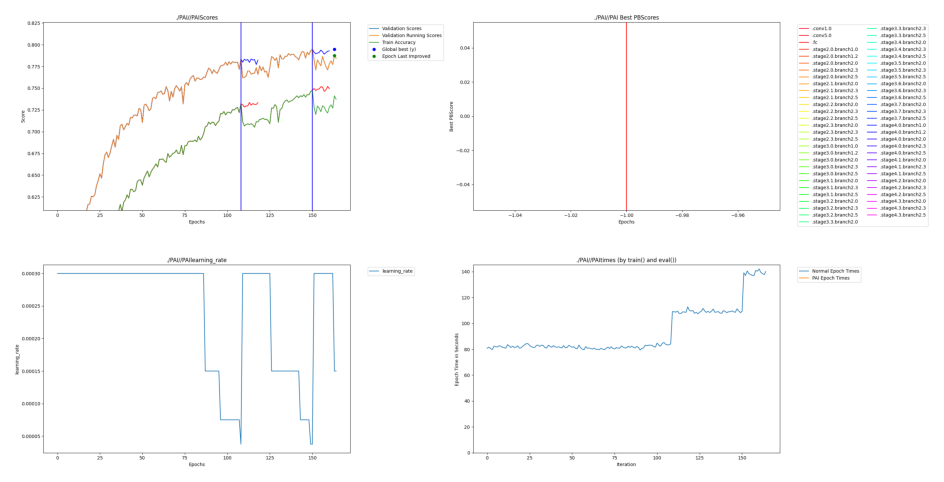

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/PerforatedAI/PAI/PAI.png")
plt.figure(figsize=(18,6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [13]:
import os
from pathlib import Path

OUT_DIR = Path("/content/CIFAR_OP")
OUT_DIR.mkdir(parents=True, exist_ok=True)

assert "hist_B" in globals(), "hist_B not found. Run B training cell first."
assert "hist_C" in globals(), "hist_C not found. Run C training cell first."

required_keys = ["epoch", "train_acc", "test_acc"]
for k in required_keys:
    assert k in hist_B, f"hist_B missing key: {k}"
    assert k in hist_C, f"hist_C missing key: {k}"

print("hist_B keys:", list(hist_B.keys()))
print("hist_C keys:", list(hist_C.keys()))
print("len B:", len(hist_B["epoch"]), "len C:", len(hist_C["epoch"]))
print("C restructure epochs:", hist_C.get("restructured_epoch", []))

# Optional: ensure epochs are ints
hist_B["epoch"] = [int(e) for e in hist_B["epoch"]]
hist_C["epoch"] = [int(e) for e in hist_C["epoch"]]

hist_B keys: ['epoch', 'train_acc', 'test_acc', 'params']
hist_C keys: ['epoch', 'train_acc', 'test_acc', 'params', 'restructured_epoch']
len B: 20 len C: 200
C restructure epochs: [118, 152, 167, 185]


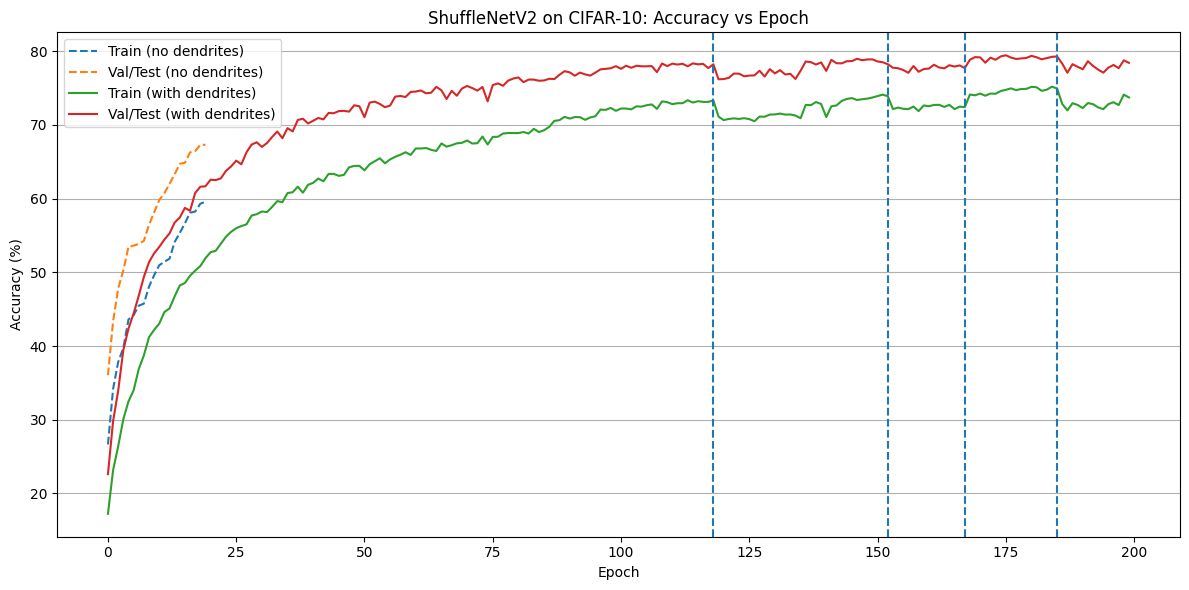

Saved: /content/CIFAR_OP/Accuracy_Improvement.png


In [14]:
import matplotlib.pyplot as plt

def save_accuracy_improvement(hist_B, hist_C, out_path):
    eB = hist_B["epoch"]
    eC = hist_C["epoch"]

    B_train = hist_B["train_acc"]
    B_val   = hist_B["test_acc"]

    C_train = hist_C["train_acc"]
    C_val   = hist_C["test_acc"]

    # Convert to %
    B_train = [x * 100 for x in B_train]
    B_val   = [x * 100 for x in B_val]
    C_train = [x * 100 for x in C_train]
    C_val   = [x * 100 for x in C_val]

    restructure_epochs = hist_C.get("restructured_epoch", []) or hist_C.get("restructured_epochs", [])

    plt.figure(figsize=(12, 6))

    # B (no dendrites)
    plt.plot(eB, B_train, linestyle="--", label="Train (no dendrites)")
    plt.plot(eB, B_val,   linestyle="--", label="Val/Test (no dendrites)")

    # C (with dendrites)
    plt.plot(eC, C_train, label="Train (with dendrites)")
    plt.plot(eC, C_val,   label="Val/Test (with dendrites)")

    # Dendrite markers
    for e in restructure_epochs:
        plt.axvline(int(e), linestyle="--")

    plt.title("ShuffleNetV2 on CIFAR-10: Accuracy vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(True, axis="y")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()

out_path = OUT_DIR / "Accuracy_Improvement.png"
save_accuracy_improvement(hist_B, hist_C, out_path)
print("Saved:", out_path)

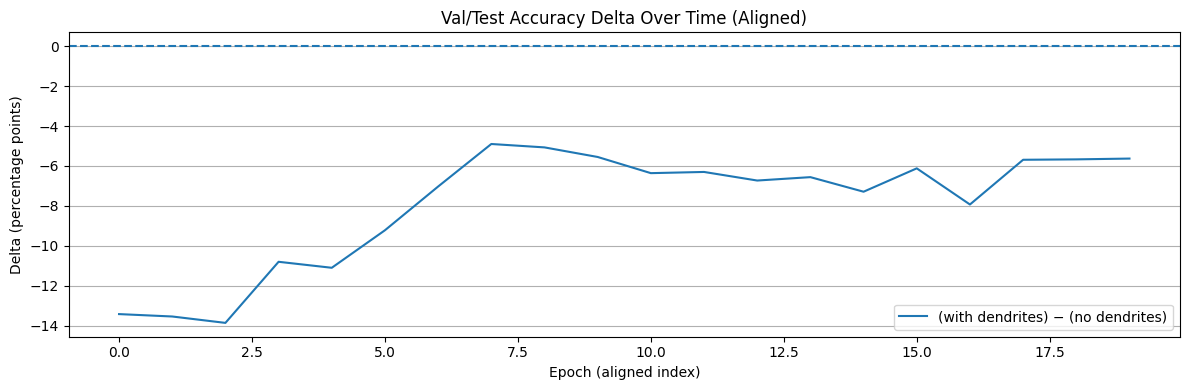

Saved: /content/CIFAR_OP/Accuracy_Delta.png


In [15]:
import numpy as np
import matplotlib.pyplot as plt

def save_accuracy_delta(hist_B, hist_C, out_path):
    B_val = hist_B["test_acc"]
    C_val = hist_C["test_acc"]

    n = min(len(B_val), len(C_val))
    if n == 0:
        raise ValueError("No accuracy values found for B/C.")

    epochs = list(range(n))
    delta = (np.array(C_val[:n]) - np.array(B_val[:n])) * 100.0  # percentage points

    plt.figure(figsize=(12, 4))
    plt.plot(epochs, delta, label="(with dendrites) − (no dendrites)")
    plt.axhline(0, linestyle="--")
    plt.title("Val/Test Accuracy Delta Over Time (Aligned)")
    plt.xlabel("Epoch (aligned index)")
    plt.ylabel("Delta (percentage points)")
    plt.grid(True, axis="y")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()

out_path = OUT_DIR / "Accuracy_Delta.png"
save_accuracy_delta(hist_B, hist_C, out_path)
print("Saved:", out_path)

In [16]:
!ls -lah /content/CIFAR_OP

total 276K
drwxr-xr-x 2 root root 4.0K Jan 19 01:53 .
drwxr-xr-x 1 root root 4.0K Jan 19 01:53 ..
-rw-r--r-- 1 root root  89K Jan 19 01:53 Accuracy_Delta.png
-rw-r--r-- 1 root root 175K Jan 19 01:53 Accuracy_Improvement.png
